In [1]:
from final_processing import final_processing_functions as fpf
import functions_for_testing_glmmlcm_registra as ftg
import os
import pandas as pd
import numpy as np
from allensdk.core.mouse_connectivity_cache import MouseConnectivityCache
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
import matplotlib.colors as colors
import seaborn as sb
from sklearn.metrics.pairwise import cosine_similarity
import ast
import pathlib
import statsmodels.formula.api as smf
%matplotlib inline


In [2]:
#lets load the datasets for each mouse
mcc = MouseConnectivityCache()
structure_tree = mcc.get_structure_tree()
mice = ['FIAA45.6a', 'FIAA45.6d', 'FIAA55.4d']
cond_prob_dict = {}
area_is_main_dict = {}
homog_across_cubelet_dict = {}
binary_homog_across_cubelet_dict = {}
for mouse in mice:
    mini_dict={}
    binary_mini_dict = {}
    parameters_path = (
    f"/camp/lab/znamenskiyp/home/shared/projects/turnerb_A1_MAPseq/{mouse}/Sequencing")
    barcodes = pd.read_pickle(f"{parameters_path}/A1_barcodes_thresholded.pkl")
    area_is_main_dict[mouse] = fpf.area_is_main(parameters_path=parameters_path, barcode_matrix = barcodes, cortical=True, shuffled=False, IT_only=True)
    mini_dict['actual']=fpf.homog_across_cubelet(parameters_path=parameters_path, barcode_matrix = barcodes, cortical=True, shuffled=False, IT_only=True, binary=False)
    mini_dict['shuffled']=fpf.homog_across_cubelet(parameters_path=parameters_path, barcode_matrix = barcodes, cortical=True, shuffled=True, IT_only=True, binary=False)
    binary_mini_dict['actual_binary'] = fpf.homog_across_cubelet(parameters_path=parameters_path, barcode_matrix = barcodes, cortical=True, shuffled=False, IT_only=True, binary=True)
    binary_mini_dict['shuffled_binary'] = fpf.homog_across_cubelet(parameters_path=parameters_path, barcode_matrix = barcodes, cortical=True, shuffled=True, IT_only=True, binary=True)
    homog_across_cubelet_dict[mouse] = mini_dict
    binary_homog_across_cubelet_dict[mouse] = binary_mini_dict
   

/nemo/lab/znamenskiyp/home/users/turnerb/code/MAPseq_processing/final_processing/final_processing_functions.py:689: RuntimeWarning: invalid value encountered in divide
  barcodes = barcodes / total_projection_strength[:, np.newaxis]
/nemo/lab/znamenskiyp/home/users/turnerb/code/MAPseq_processing/final_processing/final_processing_functions.py:689: RuntimeWarning: invalid value encountered in divide
  barcodes = barcodes / total_projection_strength[:, np.newaxis]
/nemo/lab/znamenskiyp/home/users/turnerb/code/MAPseq_processing/final_processing/final_processing_functions.py:689: RuntimeWarning: invalid value encountered in divide
  barcodes = barcodes / total_projection_strength[:, np.newaxis]


In [3]:


common_cols = set(binary_homog_across_cubelet_dict['FIAA45.6a']['actual_binary'].columns).intersection(
    set(binary_homog_across_cubelet_dict['FIAA45.6d']['actual_binary'].columns)
).intersection(
    set(binary_homog_across_cubelet_dict['FIAA55.4d']['actual_binary'].columns)
)

cols = ['VISp', 'VISal', 'VISl', 'VISli', 'VISpor', 'VISpl', 'VISam', 'VISa', 'VISpm', 'VISrl']
cols = [col for col in cols if col in common_cols]
cols_reordered = [item for item in cols if item in common_cols] + [item for item in common_cols if item not in cols]

areas_of_interest = cols  
OR_df = pd.DataFrame(columns=cols_reordered, index=cols)
pval_df = pd.DataFrame(columns=cols_reordered, index=cols)

for number_area, conditional_area in enumerate(cols):
    for number_proj_area, proj_area_x in enumerate(cols_reordered):
        if conditional_area == proj_area_x:
            pval_df.loc[conditional_area, proj_area_x] = np.nan
            OR_df.loc[conditional_area, proj_area_x] = np.nan
        else:
            combined_data = []
            for mouse, data in binary_homog_across_cubelet_dict.items():
                for dataset_type in ['shuffled_binary', 'actual_binary']:
                    df = data[dataset_type].astype(bool).astype(int)
                    df_to_look = pd.DataFrame()
                    df_cond = df[df[conditional_area] == 1]
                    df_to_look['proj_area_x'] = df_cond[[proj_area_x]].copy()
                    df_to_look['dataset'] = dataset_type
                    df_to_look['mouse'] = mouse
                    combined_data.append(df_to_look)
            
            combined_df = pd.concat(combined_data).reset_index(drop=True)
            mouse_summary = combined_df.groupby('mouse')['proj_area_x'].agg(['sum', 'count'])

            # Identify mice with all zeros or all ones
            mice_to_exclude = mouse_summary[(mouse_summary['sum'] == 0) | (mouse_summary['sum'] == mouse_summary['count'])].index
            if len(mice_to_exclude) > 0:
                combined_df = combined_df[~combined_df['mouse'].isin(mice_to_exclude)]
                print(f'excluding {mice_to_exclude[0]}, conditional_area = {conditional_area}, proj_area_x= {proj_area_x}' )
            combined_df['dataset'] = combined_df['dataset'].astype('category')
            combined_df['mouse'] = combined_df['mouse'].astype('category')
            # Fit a fixed effects logistic regression model with dataset and mouse as predictors
            model = smf.logit('proj_area_x ~ dataset + mouse', data=combined_df).fit(disp=False)
            results = model.summary2().tables[1]
            
            # Extract p-value and odds ratio for the 'datasetshuffled' effect
            pval_df.loc[conditional_area, proj_area_x] = results.loc['dataset[T.shuffled_binary]', 'P>|z|']
            OR_df.loc[conditional_area, proj_area_x] = np.exp(results.loc['dataset[T.shuffled_binary]', 'Coef.'])


excluding FIAA45.6a, conditional_area = VISpl, proj_area_x= VISl
excluding FIAA45.6a, conditional_area = VISpl, proj_area_x= MOs
excluding FIAA45.6a, conditional_area = VISpl, proj_area_x= ACAv
excluding FIAA45.6a, conditional_area = VISpl, proj_area_x= MOp
excluding FIAA45.6a, conditional_area = VISpl, proj_area_x= ACAd
excluding FIAA45.6a, conditional_area = VISpl, proj_area_x= TEa
excluding FIAA45.6a, conditional_area = VISrl, proj_area_x= MOs


In [4]:
#correct for multiple comparisons
num_tests = len(cols_reordered) * (len(cols)-1)
pval_df = pval_df*num_tests

In [5]:
common_cols = set(binary_homog_across_cubelet_dict['FIAA45.6a']['actual_binary'].columns).intersection(
    set(binary_homog_across_cubelet_dict['FIAA45.6d']['actual_binary'].columns)
).intersection(
    set(binary_homog_across_cubelet_dict['FIAA55.4d']['actual_binary'].columns)
)

cols = ['VISp', 'VISal', 'VISl', 'VISli', 'VISpor', 'VISpl', 'VISam', 'VISa', 'VISpm', 'VISrl']
cols = [col for col in cols if col in common_cols]
cols_reordered = [item for item in cols if item in common_cols] + [item for item in common_cols if item not in cols]


Let's plot correlations between shuffles for the different approaches

In [6]:
key = 'homogenous_across_cubelet'
all_combined={}
common_cols_cortex = []
for col in common_cols:
    if col not in ['Contra', 'OB']:
        structure = structure_tree.get_structures_by_acronym([col])
        if 315 in structure[0]['structure_id_path']:
            common_cols_cortex.append(col)
combined_matrix = pd.concat([binary_homog_across_cubelet_dict['FIAA45.6a']['actual_binary'][common_cols_cortex], binary_homog_across_cubelet_dict['FIAA45.6d']['actual_binary'][common_cols_cortex], binary_homog_across_cubelet_dict['FIAA55.4d']['actual_binary'][common_cols_cortex]])
cols = ['VISal', 'VISl',  'VISli','VISpor', 'VISpl', 'VISp', 'VISam', 'VISa', 'VISpm', 'VISrl']
#cols = ['VISli','VISpor', 'VISpl', 'VISl', 'VISp', 'VISal', 'VISam', 'VISpm', 'VISa', 'VISrl']
all_combined[key] = combined_matrix
all_combined['shuff_cubelet'] = pd.concat([binary_homog_across_cubelet_dict['FIAA45.6a']['shuffled_binary'][common_cols_cortex], binary_homog_across_cubelet_dict['FIAA45.6d']['shuffled_binary'][common_cols_cortex], binary_homog_across_cubelet_dict['FIAA55.4d']['shuffled_binary'][common_cols_cortex]])

<AxesSubplot:>

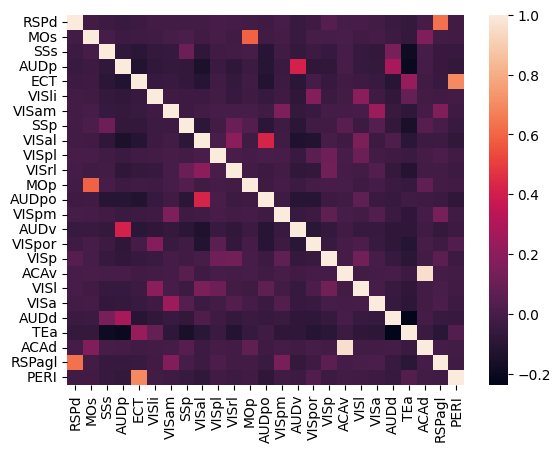

In [7]:
sb.heatmap(all_combined['shuff_cubelet'].corr())

In [7]:
conditional_probability_dict = {}
p_val_dict = {}
analysis_names =['homogenous_across_cubelet', 'shuff_cubelet']
for key in analysis_names:
    cols = ['VISal', 'VISl', 'VISli', 'VISpor', 'VISpl', 'VISp', 'VISam', 'VISa', 'VISpm', 'VISrl']
    matrix = all_combined[key].copy()
    all_cols = matrix.columns
    cols_reordered = [item for item in cols if item in all_cols] + [item for item in all_cols if item not in cols]
    cols_reordered = [item for item in cols_reordered if item != 'AUDp']
    cols = [col for col in cols if col in all_cols]
    if 'shuff' in key:
        which = key.split('shuff_')[-1]
        #conditional_prob = pd.DataFrame(data=np.zeros((len(cols), len(cols_reordered))), columns= cols_reordered, index=cols_reordered)
        if which in ('cubelet', 'area'):
            matrix_to_comp = all_combined[f'homogenous_across_{which}']
        elif which == 'main':
            matrix_to_comp= all_combined['area_is_main']
        conditional_prob = ftg.get_cond_prob(matrix=matrix_to_comp[cols_reordered], columns=cols_reordered, index=cols_reordered)
        #matrix = all_combined[f'homogenous_across_{which}'][cols_reordered]
        shuff_matrix = all_combined[key]
        shuffled_cond_prob = ftg.get_cond_prob(matrix=shuff_matrix[cols_reordered], columns=cols_reordered, index=cols_reordered)
        #shuffled_cond_prob = pd.read_pickle(f'/camp/lab/znamenskiyp/home/shared/projects/turnerb_A1_MAPseq/collated_shuffles/shuffled_{which}_conditional_prob__collated.pkl')
        #mean_val_matrix = pd.DataFrame(data=np.zeros((len(cols_reordered), len(cols_reordered))), columns= cols_reordered, index=cols_reordered)
        #p_val_matrix = pd.DataFrame(data=np.zeros((len(cols_reordered), len(cols_reordered))), columns= cols_reordered, index=cols_reordered)
        
        # for column_name in shuffled_cond_prob.columns:
        #     separated_words = column_name.split(', ')
        #     mean_corr = shuffled_cond_prob[column_name].mean()
        #     if separated_words[0] in cols_reordered and separated_words[1] in cols_reordered:
        #         mean_val_matrix.loc[separated_words[0], separated_words[1]] = mean_corr
        #         # if separated_words[1] in cols:
        #         #     mean_val_matrix.loc[separated_words[1], separated_words[0]] = mean_corr
        #         val_to_comp = conditional_prob.loc[separated_words[0], separated_words[1]]
        #         if val_to_comp >= mean_corr:
        #             p_val = (sum(1 for value in shuffled_cond_prob[column_name] if value > val_to_comp)/len(shuffled_cond_prob))*2
        #         elif val_to_comp < mean_corr:
        #             p_val = (sum(1 for value in shuffled_cond_prob[column_name] if value < val_to_comp)/len(shuffled_cond_prob))*2    
        #         #p_val = scipy.stats.norm.sf(abs(z_value))*2
        #         p_val_matrix.loc[separated_words[0], separated_words[1]] = p_val
        #         # if separated_words[1] in cols_reordered:
        #         #     p_val_matrix.loc[separated_words[1], separated_words[0]] = p_val
        # np.fill_diagonal(mean_val_matrix.values, np.nan)
        # np.fill_diagonal(p_val_matrix.values, np.nan)
        # number_tests = len(cols)* (len(cols_reordered)-1)
        # p_val_matrix = p_val_matrix*number_tests #bonferroni correction
        # p_val_dict[key] =p_val_matrix
        conditional_probability_dict[key] =shuffled_cond_prob
    else:
       conditional_probability_dict[key] = ftg.get_cond_prob(matrix=all_combined[key][cols_reordered], columns=cols_reordered, index=cols_reordered) 
    

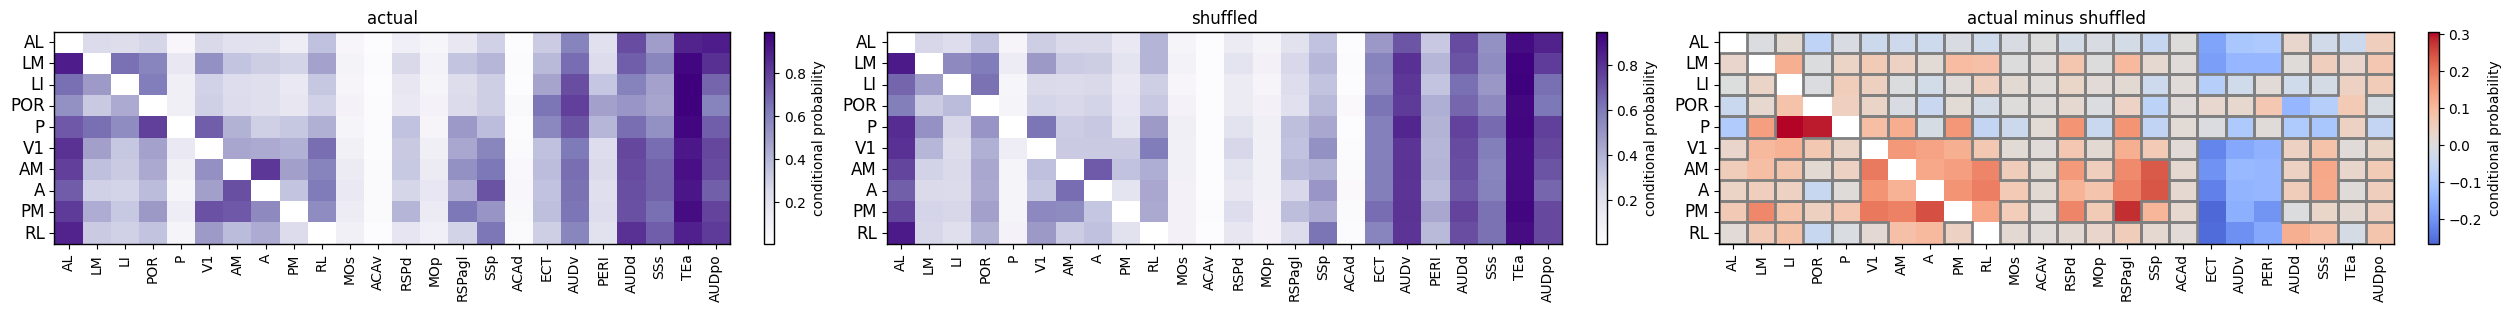

In [8]:
from matplotlib.patches import Rectangle
#analysis_names =['homogenous_across_cubelet', 'homogenous_across_area', 'area_is_main', 'shuff_cubelet', 'shuff_area']
fig, axs = plt.subplots(1, 3, figsize=(25, 3), constrained_layout=True)

titles = ['actual', 'shuffled', 'actual minus shuffled']
for analysis_num, analysis_type in enumerate(['cubelet']):
    if analysis_type != 'main':
        actual_data = conditional_probability_dict[f'homogenous_across_{analysis_type}']
    elif analysis_type == 'main':
        actual_data = conditional_probability_dict['area_is_main']
    orig_df = actual_data.copy(deep=True)
    combined_dif = actual_data - conditional_probability_dict[f'shuff_{analysis_type}']
    div_df = np.log2(actual_data / conditional_probability_dict[f'shuff_{analysis_type}'])
    div_df.replace([np.inf, -np.inf], np.nan, inplace=True)
    dfs = [actual_data, conditional_probability_dict[f'shuff_{analysis_type}'], combined_dif]
    cols = ['VISal', 'VISl', 'VISli', 'VISpor', 'VISpl', 'VISp', 'VISam', 'VISa', 'VISpm', 'VISrl']
    all_cols = actual_data.columns
    cols = [col for col in cols if col in all_cols]
    for number, title in enumerate(titles):
        data_to_use = dfs[number].copy(deep=True)
        shortened_data_names_the_same = data_to_use.loc[cols].copy(deep=True)
        shortened_data = data_to_use.loc[cols]
        if number>1:
            sb.heatmap(
                ax=axs[number], 
                data=ftg.convert_matrix_names(shortened_data), 
                cmap='coolwarm', center=0,
                xticklabels=True, 
                yticklabels=True, 
                cbar_kws={'label': 'conditional probability'})
        else:
            sb.heatmap(
                ax=axs[number], 
                data=ftg.convert_matrix_names(shortened_data), 
                cmap='Purples',
                xticklabels=True, 
                yticklabels=True, 
                cbar_kws={'label': 'conditional probability'}
            )
        axs[number].set_title(f'{titles[number]}')
        axs[number].tick_params(axis='y', which='major', labelsize=12, rotation=0)
        if analysis_type != 'main':
            if number>1:
                for ii in shortened_data_names_the_same.index:
                    for j in shortened_data_names_the_same.columns:
                        if pval_df.loc[ii, j] > 0.05:
                            row_idx = shortened_data_names_the_same.index.get_loc(ii)  # get the index of the row name
                            col_idx = shortened_data_names_the_same.columns.get_loc(j)  
                            axs[number].add_patch(Rectangle((col_idx, row_idx), 1, 1, fill=False, edgecolor='grey', lw=2))
        for _, spine in axs[number].spines.items():
            spine.set_visible(True)
            spine.set_color('black')
            spine.set_linewidth(1)
        cbar = axs[number].collections[0].colorbar
        cbar.outline.set_visible(True)
        cbar.outline.set_edgecolor('black')
        cbar.outline.set_linewidth(1)

Let's visualise as mean conditional probability

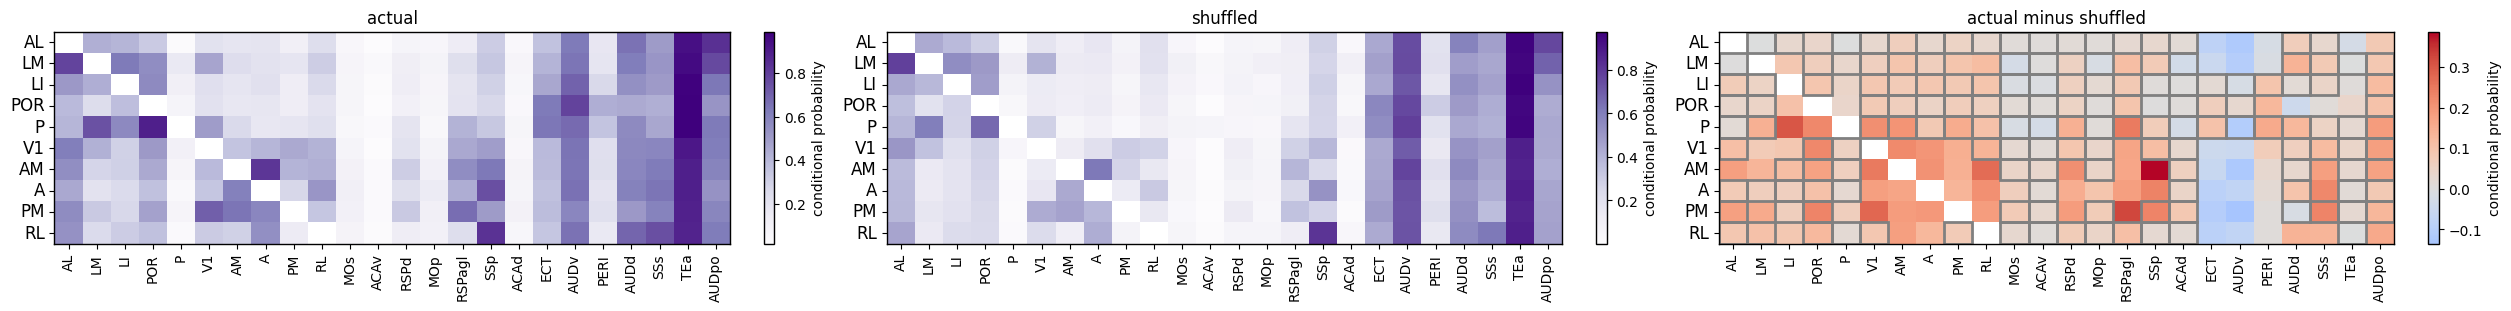

In [9]:
conditional_probability_dict = {}
p_val_dict = {}
analysis_names =['actual', 'shuffled', 'actual minus shuffled']
key = 'homogenous_across_cubelet'
fig, axs = plt.subplots(1, 3, figsize=(25, 3), constrained_layout=True)
cols = ['VISal', 'VISl', 'VISli', 'VISpor', 'VISpl', 'VISp', 'VISam', 'VISa', 'VISpm', 'VISrl']
matrix = all_combined[key].copy()
all_cols = matrix.columns
cols_reordered = [item for item in cols if item in all_cols] + [item for item in all_cols if item not in cols]
cols_reordered = [item for item in cols_reordered if item != 'AUDp']
cols = [col for col in cols if col in all_cols]
mini_dict_actual = {}
mini_dict_shuffled = {}
mini_dict_actual_minus_shuf = {}
for mouse in mice:
    homog_across_cubelet_dict[f'{mouse}']['actual'][cols_reordered]
    mini_dict_actual[mouse] = ftg.get_cond_prob(matrix=homog_across_cubelet_dict[f'{mouse}']['actual'][cols_reordered], columns=cols_reordered, index=cols_reordered) 
    mini_dict_shuffled[mouse] = ftg.get_cond_prob(matrix=homog_across_cubelet_dict[f'{mouse}']['shuffled'][cols_reordered], columns=cols_reordered, index=cols_reordered) 
    mini_dict_actual_minus_shuf[mouse] = mini_dict_actual[mouse]-mini_dict_shuffled[mouse]
for number, analysis_dict in enumerate([mini_dict_actual, mini_dict_shuffled, mini_dict_actual_minus_shuf]):
    mean_df = pd.concat(analysis_dict.values()).groupby(level=0).mean()
    mean_df= mean_df.loc[cols_reordered][cols_reordered]
    data_to_use = mean_df.copy(deep=True)
    shortened_data_names_the_same = data_to_use.loc[cols].copy(deep=True)
    shortened_data = data_to_use.loc[cols]
    if number>1:
            sb.heatmap(
                ax=axs[number], 
                data=ftg.convert_matrix_names(shortened_data), 
                cmap='coolwarm', center=0,
                xticklabels=True, 
                yticklabels=True, 
                cbar_kws={'label': 'conditional probability'})
    else:
        sb.heatmap(
            ax=axs[number], 
            data=ftg.convert_matrix_names(shortened_data), 
            cmap='Purples',
            xticklabels=True, 
            yticklabels=True, 
            cbar_kws={'label': 'conditional probability'})
    axs[number].set_title(f'{analysis_names[number]}')
    axs[number].tick_params(axis='y', which='major', labelsize=12, rotation=0)
    if analysis_type != 'main':
        if number>1:
            for ii in shortened_data_names_the_same.index:
                for j in shortened_data_names_the_same.columns:
                    if pval_df.loc[ii, j] > 0.05:
                        row_idx = shortened_data_names_the_same.index.get_loc(ii)  # get the index of the row name
                        col_idx = shortened_data_names_the_same.columns.get_loc(j)  
                        axs[number].add_patch(Rectangle((col_idx, row_idx), 1, 1, fill=False, edgecolor='grey', lw=2))
    for _, spine in axs[number].spines.items():
        spine.set_visible(True)
        spine.set_color('black')
        spine.set_linewidth(1)
    cbar = axs[number].collections[0].colorbar
    cbar.outline.set_visible(True)
    cbar.outline.set_edgecolor('black')
    cbar.outline.set_linewidth(1)

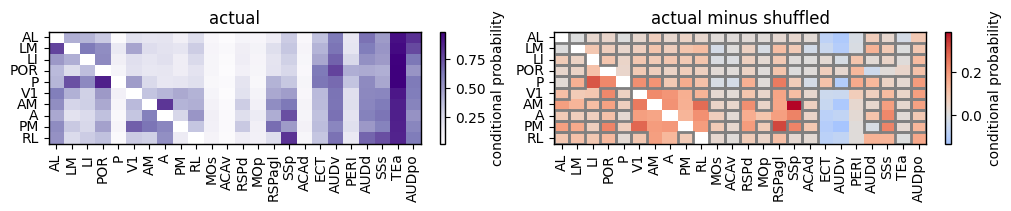

In [10]:
conditional_probability_dict = {}
p_val_dict = {}
analysis_names =['actual', 'actual minus shuffled']
key = 'homogenous_across_cubelet'
fig, axs = plt.subplots(1, 2, figsize=(10, 2), constrained_layout=True)
cols = ['VISal', 'VISl', 'VISli', 'VISpor', 'VISpl', 'VISp', 'VISam', 'VISa', 'VISpm', 'VISrl']
matrix = all_combined[key].copy()
all_cols = matrix.columns
cols_reordered = [item for item in cols if item in all_cols] + [item for item in all_cols if item not in cols]
cols_reordered = [item for item in cols_reordered if item != 'AUDp']
cols = [col for col in cols if col in all_cols]
mini_dict_actual = {}
mini_dict_shuffled = {}
mini_dict_actual_minus_shuf = {}
for mouse in mice:
    homog_across_cubelet_dict[f'{mouse}']['actual'][cols_reordered]
    mini_dict_actual[mouse] = ftg.get_cond_prob(matrix=homog_across_cubelet_dict[f'{mouse}']['actual'][cols_reordered], columns=cols_reordered, index=cols_reordered) 
    mini_dict_shuffled[mouse] = ftg.get_cond_prob(matrix=homog_across_cubelet_dict[f'{mouse}']['shuffled'][cols_reordered], columns=cols_reordered, index=cols_reordered) 
    mini_dict_actual_minus_shuf[mouse] = mini_dict_actual[mouse]-mini_dict_shuffled[mouse]
for number, analysis_dict in enumerate([mini_dict_actual, mini_dict_actual_minus_shuf]):
    mean_df = pd.concat(analysis_dict.values()).groupby(level=0).mean()
    mean_df= mean_df.loc[cols_reordered][cols_reordered]
    data_to_use = mean_df.copy(deep=True)
    shortened_data_names_the_same = data_to_use.loc[cols].copy(deep=True)
    shortened_data = data_to_use.loc[cols]
    if number==1:
            sb.heatmap(
                ax=axs[number], 
                data=ftg.convert_matrix_names(shortened_data), 
                cmap='coolwarm', center=0,
                xticklabels=True, 
                yticklabels=True, 
                cbar_kws={'label': 'conditional probability'})
    else:
        sb.heatmap(
            ax=axs[number], 
            data=ftg.convert_matrix_names(shortened_data), 
            cmap='Purples',
            xticklabels=True, 
            yticklabels=True, 
            cbar_kws={'label': 'conditional probability'})
    axs[number].set_title(f'{analysis_names[number]}')
    axs[number].tick_params(axis='y', which='major', labelsize=10, rotation=0)
    if number==1:
        for ii in shortened_data_names_the_same.index:
            for j in shortened_data_names_the_same.columns:
                if pval_df.loc[ii, j] > 0.05:
                    row_idx = shortened_data_names_the_same.index.get_loc(ii)  # get the index of the row name
                    col_idx = shortened_data_names_the_same.columns.get_loc(j)  
                    axs[number].add_patch(Rectangle((col_idx, row_idx), 1, 1, fill=False, edgecolor='grey', lw=2))
    for _, spine in axs[number].spines.items():
        spine.set_visible(True)
        spine.set_color('black')
        spine.set_linewidth(1)
    cbar = axs[number].collections[0].colorbar
    cbar.outline.set_visible(True)
    cbar.outline.set_edgecolor('black')
    cbar.outline.set_linewidth(1)

Adjusting so we're looking at all of the areas

In [14]:


common_cols = set(homog_across_cubelet_dict['FIAA45.6a']['actual'].columns).intersection(
    set(homog_across_cubelet_dict['FIAA45.6d']['actual'].columns)
).intersection(
    set(homog_across_cubelet_dict['FIAA55.4d']['actual'].columns)
)

cols = ['VISp', 'VISal', 'VISl', 'VISli', 'VISpor', 'VISpl', 'VISam', 'VISa', 'VISpm', 'VISrl']
cols = [col for col in cols if col in common_cols]
cols_reordered = [item for item in cols if item in common_cols] + [item for item in common_cols if item not in cols]

areas_of_interest = cols  
OR_df = pd.DataFrame(columns=cols_reordered, index=cols_reordered)
pval_df = pd.DataFrame(columns=cols_reordered, index=cols_reordered)
excluded_mice_dict = {}
for number_area, conditional_area in enumerate(cols_reordered):
    for number_proj_area, proj_area_x in enumerate(cols_reordered):
        if conditional_area == proj_area_x:
            pval_df.loc[conditional_area, proj_area_x] = np.nan
            OR_df.loc[conditional_area, proj_area_x] = np.nan
        else:
            combined_data = []
            for mouse, data in homog_across_cubelet_dict.items():
                for dataset_type in ['shuffled', 'actual']:
                    df = data[dataset_type].astype(bool).astype(int)
                    df_to_look = pd.DataFrame()
                    df_cond = df[df[conditional_area] == 1]
                    df_to_look['proj_area_x'] = df_cond[[proj_area_x]].copy()
                    df_to_look['dataset'] = dataset_type
                    df_to_look['mouse'] = mouse
                    combined_data.append(df_to_look)
            
            combined_df = pd.concat(combined_data).reset_index(drop=True)
            mouse_summary = combined_df.groupby('mouse')['proj_area_x'].agg(['sum', 'count'])

            # Identify mice with all zeros or all ones
            mice_to_exclude = mouse_summary[(mouse_summary['sum'] == 0) | (mouse_summary['sum'] == mouse_summary['count'])].index
            if len(mice_to_exclude) > 0:
                combined_df = combined_df[~combined_df['mouse'].isin(mice_to_exclude)]
                print(f'excluding {mice_to_exclude[0]}, conditional_area = {conditional_area}, proj_area_x= {proj_area_x}' )
                excluded_mice_dict[(conditional_area, proj_area_x)] = list(mice_to_exclude)
            combined_df['dataset'] = combined_df['dataset'].astype('category')
            combined_df['mouse'] = combined_df['mouse'].astype('category')
            if len(combined_df)<1: #in the case where all cubelets contain the areas in question, so you cannot test difference to shuffled
                pval_df.loc[conditional_area, proj_area_x] = np.nan
                OR_df.loc[conditional_area, proj_area_x] = np.nan
                excluded_mice_dict[(conditional_area, proj_area_x)] = list(mice)
                continue
            # Fit a fixed effects logistic regression model with dataset and mouse as predictors
            model = smf.logit('proj_area_x ~ dataset + mouse', data=combined_df).fit(disp=False)
            results = model.summary2().tables[1]
            
            # Extract p-value and odds ratio for the 'datasetshuffled' effect
            pval_df.loc[conditional_area, proj_area_x] = results.loc['dataset[T.shuffled]', 'P>|z|']
            OR_df.loc[conditional_area, proj_area_x] = np.exp(results.loc['dataset[T.shuffled]', 'Coef.'])


excluding FIAA55.4d, conditional_area = VISl, proj_area_x= RSPd
excluding FIAA45.6a, conditional_area = VISpl, proj_area_x= VISpor
excluding FIAA55.4d, conditional_area = VISpl, proj_area_x= VISam
excluding FIAA45.6a, conditional_area = VISpl, proj_area_x= TEa
excluding FIAA45.6a, conditional_area = VISpl, proj_area_x= MOs
excluding FIAA45.6a, conditional_area = VISpl, proj_area_x= MOp
excluding FIAA45.6a, conditional_area = VISpl, proj_area_x= ACAv
excluding FIAA45.6a, conditional_area = VISpl, proj_area_x= ACAd


/camp/home/turnerb/.conda/envs/MAPseq_processing/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


excluding FIAA55.4d, conditional_area = VISam, proj_area_x= VISpl
excluding FIAA45.6a, conditional_area = VISrl, proj_area_x= MOs
excluding FIAA45.6a, conditional_area = PERI, proj_area_x= TEa
excluding FIAA45.6a, conditional_area = PERI, proj_area_x= ECT


KeyboardInterrupt: 

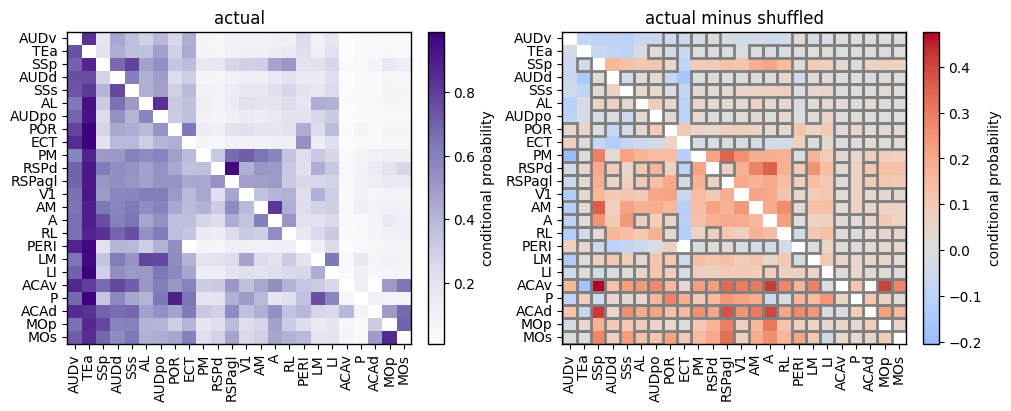

In [66]:
#all the data
#correct for multiple comparisons
num_tests = len(cols_reordered) * (len(cols_reordered)-1)
pval_df = pval_df*num_tests
conditional_probability_dict = {}
p_val_dict = {}
analysis_names =['actual', 'actual minus shuffled']
key = 'homogenous_across_cubelet'
fig, axs = plt.subplots(1, 2, figsize=(10, 4), constrained_layout=True)
cols = ['VISal', 'VISl', 'VISli', 'VISpor', 'VISpl', 'VISp', 'VISam', 'VISa', 'VISpm', 'VISrl']
matrix = all_combined[key].copy()
all_cols = matrix.columns
cols_reordered = [item for item in cols if item in all_cols] + [item for item in all_cols if item not in cols]
cols_reordered = [item for item in cols_reordered if item != 'AUDp']
cols = [col for col in cols if col in all_cols]
mini_dict_actual = {}
mini_dict_shuffled = {}
mini_dict_actual_minus_shuf = {}
for mouse in mice:
    homog_across_cubelet_dict[f'{mouse}']['actual'][cols_reordered]
    mini_dict_actual[mouse] = ftg.get_cond_prob(matrix=homog_across_cubelet_dict[f'{mouse}']['actual'][cols_reordered], columns=cols_reordered, index=cols_reordered) 
    mini_dict_shuffled[mouse] = ftg.get_cond_prob(matrix=homog_across_cubelet_dict[f'{mouse}']['shuffled'][cols_reordered], columns=cols_reordered, index=cols_reordered) 
    mini_dict_actual_minus_shuf[mouse] = mini_dict_actual[mouse]-mini_dict_shuffled[mouse]
for number, analysis_dict in enumerate([mini_dict_actual, mini_dict_actual_minus_shuf]):
    mean_dfs = []
    for mouse, matrix in analysis_dict.items():
        excluded_combinations = [
            (cond_area, proj_area) for (cond_area, proj_area), mice in excluded_mice_dict.items() if mouse in mice
        ]
        masked_matrix = matrix.copy()
        for cond_area, proj_area in excluded_combinations:
            masked_matrix.loc[cond_area, proj_area] = np.nan
        mean_dfs.append(masked_matrix)

    # Calculate mean excluding NaNs
    mean_df = pd.concat(mean_dfs).groupby(level=0).mean()
    mean_df =mean_df.loc[cols_reordered, cols_reordered]
    if number == 0:
        to_clust = mean_df.replace(np.nan, 0)
        cluster_grid = sb.clustermap(to_clust, metric='canberra')
        row_order = cluster_grid.dendrogram_col.reordered_ind
        row_labels = [to_clust.columns[i] for i in row_order]
        plt.close()
    mean_df = mean_df.loc[row_labels, row_labels]
    data_to_use = mean_df.copy(deep=True)
    shortened_data_names_the_same = data_to_use.copy(deep=True)
    shortened_data = data_to_use
    if number==1:
            sb.heatmap(
                ax=axs[number], 
                data=ftg.convert_matrix_names(shortened_data), 
                cmap='coolwarm', center=0,
                xticklabels=True, 
                yticklabels=True, 
                cbar_kws={'label': 'conditional probability'})
    else:
        sb.heatmap(
            ax=axs[number], 
            data=ftg.convert_matrix_names(shortened_data), 
            cmap='Purples',
            xticklabels=True, 
            yticklabels=True, 
            cbar_kws={'label': 'conditional probability'})
    axs[number].set_title(f'{analysis_names[number]}')
    axs[number].tick_params(axis='y', which='major', labelsize=10, rotation=0)
    if number==1:
        for ii in shortened_data_names_the_same.index:
            for j in shortened_data_names_the_same.columns:
                if pval_df.loc[ii, j] > 0.05:
                    row_idx = shortened_data_names_the_same.index.get_loc(ii)  # get the index of the row name
                    col_idx = shortened_data_names_the_same.columns.get_loc(j)  
                    axs[number].add_patch(Rectangle((col_idx, row_idx), 1, 1, fill=False, edgecolor='grey', lw=2))
    for _, spine in axs[number].spines.items():
        spine.set_visible(True)
        spine.set_color('black')
        spine.set_linewidth(1)
    cbar = axs[number].collections[0].colorbar
    cbar.outline.set_visible(True)
    cbar.outline.set_edgecolor('black')
    cbar.outline.set_linewidth(1)

Now let's do cosine similarity

In [68]:
mice = ['FIAA45.6a', 'FIAA45.6d', 'FIAA55.4d']
mcc = MouseConnectivityCache()
structure_tree = mcc.get_structure_tree()
combined_dict = {}
for num, mouse in enumerate(mice):
    new_dict = {}
    parameters_path = (
    f"/camp/lab/znamenskiyp/home/shared/projects/turnerb_A1_MAPseq/{mouse}/Sequencing")
    barcodes = pd.read_pickle(f"{parameters_path}/A1_barcodes_thresholded.pkl")
    new_dict['homogenous_across_cubelet'] = fpf.homog_across_cubelet(parameters_path=parameters_path, barcode_matrix = barcodes, cortical=True, shuffled=False, dummy_data=False, IT_only=True, area_threshold=0.1)
    new_dict['homogenous_across_area'] = fpf.homog_across_area(parameters_path=parameters_path, barcode_matrix = barcodes, cortical=True, shuffled=False, IT_only=True)
    new_dict['area_is_main'] = fpf.area_is_main(parameters_path=parameters_path, barcode_matrix = barcodes, cortical=False, shuffled=False,  IT_only=True)
    new_dict['shuff_cubelet']= fpf.homog_across_cubelet(parameters_path=parameters_path, barcode_matrix = barcodes, cortical=True, shuffled=True, dummy_data=False, IT_only=True)
    new_dict['shuff_area']=fpf.homog_across_area(parameters_path=parameters_path, barcode_matrix = barcodes, cortical=True, shuffled=True, IT_only=True)
    new_dict['shuff_main'] = fpf.area_is_main(parameters_path=parameters_path, barcode_matrix = barcodes, cortical=True, shuffled=True,  IT_only=True)
    combined_dict[mouse] = new_dict
analysis_names =['homogenous_across_cubelet', 'homogenous_across_area', 'area_is_main', 'shuff_cubelet', 'shuff_area', 'shuff_main']
all_combined = {}
for i, key in enumerate(analysis_names):
    #common_columns = set(combined_dict['FIAA45.6a'][key].columns).intersection(combined_dict['FIAA45.6d'][key].columns)
    common_columns = set(combined_dict['FIAA45.6a'][key].columns).intersection(
    set(combined_dict['FIAA45.6d'][key].columns)
).intersection(
    set(combined_dict['FIAA55.4d'][key].columns)
)
    common_cols_cortex = []
    for col in common_columns:
        if col not in ['Contra', 'OB']:
            structure = structure_tree.get_structures_by_acronym([col])
            if 315 in structure[0]['structure_id_path']:
                common_cols_cortex.append(col)
    combined_matrix = pd.concat([combined_dict['FIAA45.6a'][key][common_cols_cortex], combined_dict['FIAA45.6d'][key][common_cols_cortex], combined_dict['FIAA55.4d'][key][common_cols_cortex]])
    cols = ['VISal', 'VISl',  'VISli','VISpor', 'VISpl', 'VISp', 'VISam', 'VISa', 'VISpm', 'VISrl']
    #cols = ['VISli','VISpor', 'VISpl', 'VISl', 'VISp', 'VISal', 'VISam', 'VISpm', 'VISa', 'VISrl']
    all_combined[key] = combined_matrix

/nemo/lab/znamenskiyp/home/users/turnerb/code/MAPseq_processing/final_processing/final_processing_functions.py:700: RuntimeWarning: invalid value encountered in divide
  barcodes = barcodes / total_projection_strength[:, np.newaxis]
/nemo/lab/znamenskiyp/home/users/turnerb/code/MAPseq_processing/final_processing/final_processing_functions.py:918: RuntimeWarning: invalid value encountered in divide
  normalised_bc_matrix = barcodes_matrix / total_projection_strength[:, np.newaxis]
/nemo/lab/znamenskiyp/home/users/turnerb/code/MAPseq_processing/final_processing/final_processing_functions.py:2856: RuntimeWarning: invalid value encountered in divide
  barcodes = barcodes / total_projection_strength[:, np.newaxis]
/nemo/lab/znamenskiyp/home/users/turnerb/code/MAPseq_processing/final_processing/final_processing_functions.py:700: RuntimeWarning: invalid value encountered in divide
  barcodes = barcodes / total_projection_strength[:, np.newaxis]
/nemo/lab/znamenskiyp/home/users/turnerb/code/MA

In [71]:
def get_cond_prob(matrix, columns, index):
    """ function to get the conditional probability a neuron projects to an area (column) given it projects to another area (index)"""
    conditional_prob = pd.DataFrame(data=np.zeros((len(index), len(columns))), columns= columns, index=index)
    matrix = matrix[columns]
    for col in index:
        for area in columns:
            if col == area:
                conditional_prob.loc[col, area] = np.nan
            else:
                conditional_prob.loc[col, area] = matrix[matrix[col]>0].astype(bool).astype(int)[area].mean()
    return conditional_prob

In [72]:
def get_cosine_sim_of_probs(matrix, cols):
    cosine_sim_matrix = pd.DataFrame(data=np.zeros((len(cols), len(cols))), columns= cols, index=cols)
    for col in cols:
        for col_2 in cols:
            neurons_1 = matrix.loc[col]
            neurons_2 = matrix.loc[col_2]
            neurons_1 =neurons_1.drop([col, col_2])
            neurons_2 =neurons_2.drop([col, col_2])
            bl = np.array(neurons_1).reshape(1, -1)
            bl_2 = np.array(neurons_2).reshape(1, -1)
            cosine_sim = cosine_similarity(bl, bl_2)
            cosine_sim_matrix.loc[col, col_2] = cosine_sim[0][0]
            cosine_sim_matrix.loc[col_2, col] = cosine_sim[0][0]
    np.fill_diagonal(cosine_sim_matrix.values, np.nan)
    return cosine_sim_matrix

In [73]:
#let's first calculate the mean conditional probability across mice
key='homogenous_across_cubelet'
which = 'cubelet'
shuff = f'shuff_{which}'
common_cols = all_combined[key].columns
cols = ['VISal', 'VISl', 'VISli', 'VISpor', 'VISpl', 'VISp', 'VISam', 'VISa', 'VISpm', 'VISrl']
cols = [col for col in cols if col in common_cols]
cols_reordered = [item for item in cols if item in common_cols] + [item for item in common_cols if item not in cols]
cols_reordered = [item for item in cols_reordered if item != 'AUDp']
cond_prob_dict = {}
shuff_cond_prob_dict = {}
mouse_cond_prob_minus_shuff = {}
for mouse in mice:
    cond_prob_dict[mouse]= get_cond_prob(matrix = combined_dict[mouse][key], columns = cols_reordered, index = cols_reordered)
    shuff_cond_prob_dict[mouse] = get_cond_prob(matrix = combined_dict[mouse][shuff], columns = cols_reordered, index = cols_reordered)
    shuffled_cond_prob = pd.read_pickle(f'/camp/lab/znamenskiyp/home/shared/projects/turnerb_A1_MAPseq/collated_shuffles/shuffled_{which}_conditional_prob_{mouse}_collated.pkl')
    mean_val_matrix = pd.DataFrame(data=np.zeros((len(cols_reordered), len(cols_reordered))), columns= cols_reordered, index=cols_reordered)
    for column_name in shuffled_cond_prob.columns:
        separated_words = column_name.split(', ')
        mean_corr = shuffled_cond_prob[column_name].mean()
        if separated_words[0] in cols_reordered and separated_words[1] in cols_reordered:
                mean_val_matrix.loc[separated_words[0], separated_words[1]] = mean_corr
    #shuff_cond_prob_dict[mouse] = mean_val_matrix
    mouse_cond_prob_minus_shuff[mouse] = cond_prob_dict[mouse]-mean_val_matrix



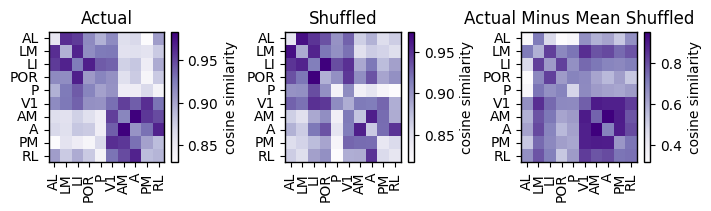

In [77]:
import itertools
fig, axs = plt.subplots(1, 3, figsize=(7, 2), constrained_layout = True)
which_ones = [cond_prob_dict, shuff_cond_prob_dict, mouse_cond_prob_minus_shuff]
#dict_to_look = mouse_cond_prob_minus_shuff
title = ['Actual', 'Shuffled', 'Actual Minus Mean Shuffled']
cosine_dict = {}
for i, dict_to_look in enumerate(which_ones):
    for mouse in mice:
        cosine_dict[mouse] = get_cosine_sim_of_probs(matrix=dict_to_look[mouse], cols = cols)
    #now for every value, get the cosine sim to itself
    to_itself_cosine = {}
    for area in cols:
        area_list = []
        for mouse_a, mouse_b in list(itertools.combinations(mice, 2)):
            neurons_1 = dict_to_look[mouse_a].loc[area]
            neurons_2 = dict_to_look[mouse_b].loc[area]
            neurons_1 =neurons_1.drop([area])
            neurons_2 =neurons_2.drop([area])
            bl = np.array(neurons_1).reshape(1, -1)
            bl_2 = np.array(neurons_2).reshape(1, -1)
            area_list.append(cosine_similarity(bl, bl_2))
        to_itself_cosine[area] = np.mean(area_list)
    cosine_df = pd.concat(cosine_dict.values()).groupby(level=0).mean()
    cosine_df= cosine_df.loc[cols][cols]
    for col in cols:
        cosine_df.loc[col, col] = to_itself_cosine[col]
    sb.heatmap(ax=axs[i], data=fpf.convert_matrix_names(cosine_df), cmap='Purples', xticklabels=True, yticklabels=True, cbar_kws={'label': 'cosine similarity'}) 
    axs[i].set_title(f'{title[i]}')
    axs[i].tick_params(axis='y', which='major', labelsize=10, rotation=0)
    axs[i].tick_params(axis='x', which='major', labelsize=10)
    for _, spine in axs[i].spines.items():
            spine.set_visible(True)
            spine.set_color('black')
            spine.set_linewidth(1)
    cbar = axs[i].collections[0].colorbar
    cbar.outline.set_visible(True)
    cbar.outline.set_edgecolor('black')
    cbar.outline.set_linewidth(1)

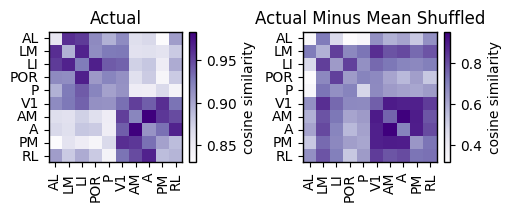

In [81]:
# for visualisation, only plot actual and actual minus shuff cosine sim
import itertools
fig, axs = plt.subplots(1, 2, figsize=(5, 2), constrained_layout = True)
which_ones = [cond_prob_dict, mouse_cond_prob_minus_shuff]
#dict_to_look = mouse_cond_prob_minus_shuff
title = ['Actual', 'Actual Minus Mean Shuffled']
cosine_dict = {}
for i, dict_to_look in enumerate(which_ones):
    for mouse in mice:
        cosine_dict[mouse] = get_cosine_sim_of_probs(matrix=dict_to_look[mouse], cols = cols)
    #now for every value, get the cosine sim to itself
    to_itself_cosine = {}
    for area in cols:
        area_list = []
        for mouse_a, mouse_b in list(itertools.combinations(mice, 2)):
            neurons_1 = dict_to_look[mouse_a].loc[area]
            neurons_2 = dict_to_look[mouse_b].loc[area]
            neurons_1 =neurons_1.drop([area])
            neurons_2 =neurons_2.drop([area])
            bl = np.array(neurons_1).reshape(1, -1)
            bl_2 = np.array(neurons_2).reshape(1, -1)
            area_list.append(cosine_similarity(bl, bl_2))
        to_itself_cosine[area] = np.mean(area_list)
    cosine_df = pd.concat(cosine_dict.values()).groupby(level=0).mean()
    cosine_df= cosine_df.loc[cols][cols]
    for col in cols:
        cosine_df.loc[col, col] = to_itself_cosine[col]
    sb.heatmap(ax=axs[i], data=fpf.convert_matrix_names(cosine_df), cmap='Purples', xticklabels=True, yticklabels=True, cbar_kws={'label': 'cosine similarity'}) 
    axs[i].set_title(f'{title[i]}')
    axs[i].tick_params(axis='y', which='major', labelsize=10, rotation=0)
    axs[i].tick_params(axis='x', which='major', labelsize=10)
    for _, spine in axs[i].spines.items():
            spine.set_visible(True)
            spine.set_color('black')
            spine.set_linewidth(1)
    cbar = axs[i].collections[0].colorbar
    cbar.outline.set_visible(True)
    cbar.outline.set_edgecolor('black')
    cbar.outline.set_linewidth(1)